<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
pip install keras-metrics

In [38]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [43]:
data_dir = "/content/drive/My Drive/dataset/video_data"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 60

classes = ["Child's room", "Office", "Museum", "Restaurant"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1

    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break

    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  4


In [44]:
X, Y = create_data(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Child's room
Office
Defected frame
Museum
Restaurant
(591, 60, 64, 64, 3)
(148, 60, 64, 64, 3)
(591, 4)
(148, 4)


In [48]:
model = Sequential()

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=True, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size = (1, 2, 2)))
model.add(Dropout(0.2))

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format="channels_last"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

#history = model.fit(x=X_train, y=y_train, epochs=40, batch_size=8, shuffle=True, validation_split=0.2, callbacks=callbacks)
history = model.fit(x=X_train, y=y_train, epochs=70, batch_size=8, shuffle=True, validation_split=0.2)
print("Accuracy : %.4f" % (model.evaluate(X_test, y_test)[1]))

# Result
loss, acc = model.evaluate(X_test, y_test)
print("\nLoss: {}, Acc: {}".format(loss,acc))


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_40 (ConvLSTM2D) (None, 60, 62, 62, 64)    154624    
_________________________________________________________________
dropout_61 (Dropout)         (None, 60, 62, 62, 64)    0         
_________________________________________________________________
conv_lst_m2d_41 (ConvLSTM2D) (None, 60, 60, 32)        110720    
_________________________________________________________________
dropout_62 (Dropout)         (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 115200)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               29491456  
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)             

ValueError: ignored

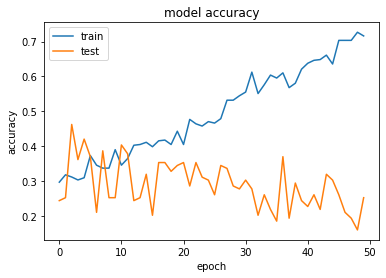

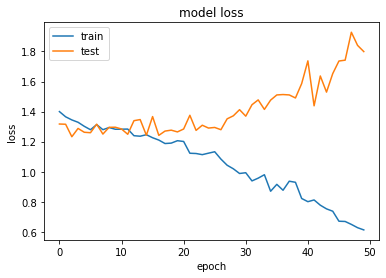

result:  0
actual result:  [1 0 0 0]
report

              precision    recall  f1-score   support

           0       0.48      0.64      0.55        36
           1       0.00      0.00      0.00        17
           2       0.13      0.14      0.13        49
           3       0.05      0.04      0.04        46

    accuracy                           0.22       148
   macro avg       0.16      0.21      0.18       148
weighted avg       0.17      0.22      0.19       148



In [47]:
## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predictions = model.predict(X_test)
print('result: ',np.argmax(predictions[0]))
print('actual result: ', y_test[0])

# Evaluation of model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
#print('y_test: ', y_test)
print('report\n')
print(classification_report(y_test, y_pred))


In [ ]:
# Confusion Matrix
#y_true = [1,0,0,0]
cm = confusion_matrix(y_test, y_pred) 
print('confusion matrix: ', cm)

confusion matrix:  [[23  0 13  0]
 [ 4  0 13  0]
 [13  0 31  5]
 [ 8  0 37  1]]
